# BMIN5220 Project: Topic Modeling on Meditation and Mindfulness Publications

**Problem Statement**:

Meditation and mindfulness exercises are practices of the mind and body, and they have a long history within Eastern cultures. There are a wide variety of methods with varied level of scientific support on their effectiveness. Generally, meditation is believed to help individuals bring calmness, cope with illnesses, and enhancing overall wellbeing. Specifically, research has shown benefits of these practices on a variety of health issues, such as stress, anxiety, depression, high blood pressure, pain, sleep quality, substance use disorder, post-traumatic stress disorder, cancer, eating disorder, and attention-deficit hyperactivity disorder

In recent years, the growth in meditation app market suggests an increase in interest in adopting these techniques by the public. The estimated revenue of the mediation market for 2023 is $4.4 billions and it is estimated to reach $7.1 billion in 2028, which is growing at 9.8% annually. Similarly, in the research community, there is also an increase in meditation and mindfulness studies. Up until November 2023, there are approximately 2,700 clinical and controlled studies, and 50% of these studies were conducted within the past 6 years. With these macro trends in mind, this study aims to use a natural language processing technique Latent Dirichlet Allocation (LDA) to conduct topic modeling to understand topic and population investigated in association with meditation and mindfulness research. Given the potential benefits of mindfulness practice and relative low cost and mild intrusion on the physical body, it has a potential to be a practice to be supported by public health initiatives.

For **Solution** and **Method**, please see accompanying documentation.

# Set Up: Library Install & Import

If you do not have the following libraries install, uncomment the following lines to install them

In [3]:
# pip install wordcloud
# !pip install metapub
# pip install gensim

## Library Imports


In [1]:
# for scrapping publication abstract
import metapub
from metapub import PubMedFetcher

# for EDA
import pandas as pd
import numpy as np

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict


# for NLP
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# for LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim.models import CoherenceModel
from gensim import models
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import gensim.corpora as corpora

# OS
import time

2023-12-18 18:40:50 Liang-Yuns-MacBook-Air.local metapub.config[48757] WARNING NCBI_API_KEY was not set.
2023-12-18 18:40:51 Liang-Yuns-MacBook-Air.local numexpr.utils[48757] INFO NumExpr defaulting to 8 threads.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liangyuncheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liangyuncheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/liangyuncheng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/liangyuncheng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 0: Data scraping

## 0.1: Obtain a List of PubMed Id

Conduct search on [PubMed](https://pubmed.ncbi.nlm.nih.gov/) using the following keywords:

("meditat*"[Title/Abstract] OR "mindful*"[Title/Abstract]) AND ("clinical trial"[Publication Type] OR "controlled*"[Publication Type] OR "Observational Study"[Publication Type])

For a list of article types: [Link](https://pubmed.ncbi.nlm.nih.gov/help/#publication-types)

Use side filter to limit search to articles with [Publication Date] ending before Nov 30, 2023.

Once search is finalized, download the search result into as a csv file.
Save > Selection: All Results > Format: CSV

## 0.2 Scraping Abstract using PubMed Id (PMID)

[Abstract] of articles are not avaiable in the downloaded seach result, so we need to scrape it using metapub API.

In [5]:
pubmed_df = pd.read_csv("0_Data//pubmed_subset.csv")

# ensure the total number matches with the online search results
pubmed_df.drop_duplicates(inplace = True)
pubmed_df.sort_values(by = ['PMID'], inplace = True, ascending = False)
pubmed_df.reset_index(inplace = True, drop = True)
pubmed_df.head()

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI
0,38030988,Reducing fear and avoidance of memory loss imp...,"Farina FR, Regan J, Marquez M, An H, O'Loughli...",BMC Geriatr. 2023 Nov 29;23(1):786. doi: 10.11...,Farina FR,BMC Geriatr,2023,2023/11/29,PMC10688470,NaN,10.1186/s12877-023-04470-4
1,38026460,Effects of a Mind-Body Program for Chronic Pai...,"LaRowe LR, Bakhshaie J, Vranceanu AM, Greenber...",J Pain Res. 2023 Nov 15;16:3917-3924. doi: 10....,LaRowe LR,J Pain Res,2023,2023/11/29,PMC10657545,NaN,10.2147/JPR.S435639
2,38026380,Efficacy of mHealth aided 12-week meditation a...,"Bhardwaj P, Pathania M, Bahurupi Y, Kanchibhot...",Front Public Health. 2023 Nov 1;11:1258330. do...,Bhardwaj P,Front Public Health,2023,2023/11/29,PMC10646346,NaN,10.3389/fpubh.2023.1258330
3,38010787,Effects and Mechanisms of a Web- and Mobile-Ba...,"Lu Y, Li Y, Huang Y, Zhang X, Wang J, Wu L, Ca...",J Med Internet Res. 2023 Nov 27;25:e51549. doi...,Lu Y,J Med Internet Res,2023,2023/11/27,PMC10714267,NaN,10.2196/51549
4,38001316,The effect of ten versus twenty minutes of min...,"Palmer R, Roos C, Vafaie N, Kober H.",Sci Rep. 2023 Nov 24;13(1):20646. doi: 10.1038...,Palmer R,Sci Rep,2023,2023/11/24,PMC10673854,NaN,10.1038/s41598-023-46578-y


In [106]:
# fetching data
fetch = PubMedFetcher()
start = time.time()
column_name = ['pmid', 'title', 'abstract', 'publication_type', 'link']
# pmids_list = pubmed_df['PMID'].to_list()
# run on 10 records for example
pmids_list = pubmed_df['PMID'].to_list()[:10]
scrape_df = pd.DataFrame(columns = column_name)

# note: the API is not very stable. Recommend scraping and saving scraped results in batches (100-200 articles).

batch_size = 5
total_docs = len(pmids_list)
for i in range(0, total_docs, batch_size):
  pmids = pmids_list[i: i+batch_size]
  for pmid in pmids:
    pmid_obj = fetch.article_by_pmid(pmid)
    title = pmid_obj.title
    abstract = pmid_obj.abstract
    pub_type = pmid_obj.pubmed_type
    link = "https://pubmed.ncbi.nlm.nih.gov/"+ str(pmid) +"/"
    temp_df = pd.DataFrame([(pmid, title, abstract, pub_type, link)], columns = column_name)
    scrape_df = pd.concat([scrape_df, temp_df])
  filename = str(i) + "_" + str(i + (batch_size - 1)) + ".csv"
  scrape_df.to_csv(filename)
end = time.time()
duration = end - start
print("Time to read: {} seconds".format(round(duration, 3)))

Time to read: 5.865 seconds


In [107]:
scrape_df.head()

,pmid,title,abstract,publication_type,link
0,38030988,Reducing fear and avoidance of memory loss imp...,BACKGROUND: Alzheimer's disease and related de...,article,https://pubmed.ncbi.nlm.nih.gov/38030988/
0,38026460,Effects of a Mind-Body Program for Chronic Pai...,PURPOSE: Improving physical function is key to...,article,https://pubmed.ncbi.nlm.nih.gov/38026460/
0,38026380,Efficacy of mHealth aided 12-week meditation a...,"INTRODUCTION: Burnout is ""Chronic workplace st...",article,https://pubmed.ncbi.nlm.nih.gov/38026380/
0,38010787,Effects and Mechanisms of a Web- and Mobile-Ba...,BACKGROUND: Acceptance and commitment therapy ...,article,https://pubmed.ncbi.nlm.nih.gov/38010787/
0,38001316,The effect of ten versus twenty minutes of min...,"We aimed to elucidate the effects of ""dose"" of...",article,https://pubmed.ncbi.nlm.nih.gov/38001316/


Once everything is scraped in batches, files are imported and combined into 1 file. 

In [ ]:
# # Combine all scraped data into 1 file
abstract_df = pd.DataFrame()

total_export_files = 69
for i in range(1, total_export_files):
  filename = "PubMedData" + str(i) + ".csv"
  temp_df = pd.read_csv(filename)
  abstract_df = pd.concat([abstract_df, temp_df])

abstract_df.drop_duplicates(inplace = True)
abstract_df.sort_values(by = ['pmid'], inplace = True, ascending = False)
abstract_df.reset_index(inplace = True, drop = True)

abstract_df.to_csv("metapub_abstract_v2.csv", index = False)

# 1: Data Preparation

## 1.1: Import Data

In [108]:
# import original file downloaded from PubMed
field_type = {"PMID": 'string'}
pubmed_df = pd.read_csv("0_Data/pubmed_subset.csv", dtype = field_type)

# ensure the total number matches with the online search results
pubmed_df.drop_duplicates(inplace = True)
pubmed_df.sort_values(by = ['PMID'], inplace = True, ascending = False)
pubmed_df.reset_index(inplace = True, drop = True)
len(pubmed_df)

3085

In [102]:
pubmed_df.head()

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI
0,38030988,Reducing fear and avoidance of memory loss imp...,"Farina FR, Regan J, Marquez M, An H, O'Loughli...",BMC Geriatr. 2023 Nov 29;23(1):786. doi: 10.11...,Farina FR,BMC Geriatr,2023,2023/11/29,PMC10688470,NaN,10.1186/s12877-023-04470-4
1,38026460,Effects of a Mind-Body Program for Chronic Pai...,"LaRowe LR, Bakhshaie J, Vranceanu AM, Greenber...",J Pain Res. 2023 Nov 15;16:3917-3924. doi: 10....,LaRowe LR,J Pain Res,2023,2023/11/29,PMC10657545,NaN,10.2147/JPR.S435639
2,38026380,Efficacy of mHealth aided 12-week meditation a...,"Bhardwaj P, Pathania M, Bahurupi Y, Kanchibhot...",Front Public Health. 2023 Nov 1;11:1258330. do...,Bhardwaj P,Front Public Health,2023,2023/11/29,PMC10646346,NaN,10.3389/fpubh.2023.1258330
3,38010787,Effects and Mechanisms of a Web- and Mobile-Ba...,"Lu Y, Li Y, Huang Y, Zhang X, Wang J, Wu L, Ca...",J Med Internet Res. 2023 Nov 27;25:e51549. doi...,Lu Y,J Med Internet Res,2023,2023/11/27,PMC10714267,NaN,10.2196/51549
4,38001316,The effect of ten versus twenty minutes of min...,"Palmer R, Roos C, Vafaie N, Kober H.",Sci Rep. 2023 Nov 24;13(1):20646. doi: 10.1038...,Palmer R,Sci Rep,2023,2023/11/24,PMC10673854,NaN,10.1038/s41598-023-46578-y


In [109]:
# import the file contained abstract

# note: in the first version, I scraped 18000 records with a less restricted search result.
field_type = {"pmid": 'string'}
abstract_df = pd.read_csv("0_Data/metapub_abstract_v2.csv", dtype = field_type)
abstract_df.drop_duplicates(inplace = True)

abstract_df.sort_values(by = ['pmid'], inplace = True, ascending = False)
abstract_df.reset_index(inplace = True, drop = True)
len(abstract_df)

18329

In [103]:
abstract_df.head()

,Unnamed: 0,pmid,title,abstract,publication_type,link
0,0,995847,[Critical thoughts to the article by B. Staehe...,NaN,article,https://pubmed.ncbi.nlm.nih.gov/995847/
1,0,9950067,A 15O-H2O PET study of meditation and the rest...,The aim of the present study was to examine wh...,article,https://pubmed.ncbi.nlm.nih.gov/9950067/
2,0,990345,Self-regulation of response patterning: implic...,This paper develops the basic premise that lea...,article,https://pubmed.ncbi.nlm.nih.gov/990345/
3,0,9891256,Effects of mindfulness-based stress reduction ...,The inability to cope successfully with the en...,article,https://pubmed.ncbi.nlm.nih.gov/9891256/
4,0,9830942,Experiences of administering and receiving the...,This article describes the experiences of a pr...,article,https://pubmed.ncbi.nlm.nih.gov/9830942/


## 1.2: Merge Data

In [110]:
# merge the two files 
merge_df = pd.merge(pubmed_df, abstract_df, left_on = 'PMID', right_on = 'pmid', how = 'left')
merge_df.drop(columns = ['Unnamed: 0', 'pmid', 'title', 'PMCID', 'NIHMS ID'], inplace = True)
len(merge_df)

3085

In [111]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3085 entries, 0 to 3084
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              3085 non-null   string
 1   Title             3085 non-null   object
 2   Authors           3084 non-null   object
 3   Citation          3085 non-null   object
 4   First Author      3084 non-null   object
 5   Journal/Book      3085 non-null   object
 6   Publication Year  3085 non-null   int64 
 7   Create Date       3085 non-null   object
 8   DOI               2999 non-null   object
 9   abstract          2960 non-null   object
 10  publication_type  3084 non-null   object
 11  link              3084 non-null   object
dtypes: int64(1), object(10), string(1)
memory usage: 313.3+ KB


In [112]:
merge_df.head()

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,DOI,abstract,publication_type,link
0,9891256,Effects of mindfulness-based stress reduction ...,"Shapiro SL, Schwartz GE, Bonner G.",J Behav Med. 1998 Dec;21(6):581-99. doi: 10.10...,Shapiro SL,J Behav Med,1998,1999/01/19,10.1023/a:1018700829825,The inability to cope successfully with the en...,article,https://pubmed.ncbi.nlm.nih.gov/9891256/
1,9773769,Influence of a mindfulness meditation-based st...,"Kabat-Zinn J, Wheeler E, Light T, Skillings A,...",Psychosom Med. 1998 Sep-Oct;60(5):625-32. doi:...,Kabat-Zinn J,Psychosom Med,1998,1998/10/17,10.1097/00006842-199809000-00020,OBJECTIVE: This study tests the hypothesis tha...,article,https://pubmed.ncbi.nlm.nih.gov/9773769/
2,9748098,ACTH and beta-endorphin in transcendental medi...,"Infante JR, Peran F, Martinez M, Roldan A, Poy...",Physiol Behav. 1998 Jun 1;64(3):311-5. doi: 10...,Infante JR,Physiol Behav,1998,1998/09/25,10.1016/s0031-9384(98)00071-7,We have evaluated the effect of Transcendental...,article,https://pubmed.ncbi.nlm.nih.gov/9748098/
3,9532318,Clinical study of yoga techniques in universit...,"Vedanthan PK, Kesavalu LN, Murthy KC, Duvall K...",Allergy Asthma Proc. 1998 Jan-Feb;19(1):3-9. d...,Vedanthan PK,Allergy Asthma Proc,1998,1998/04/09,10.2500/108854198778557971,"Adult asthmatics, ranging from 19 to 52 years ...",article,https://pubmed.ncbi.nlm.nih.gov/9532318/
4,9513794,Autonomic changes while mentally repeating two...,"Telles S, Nagarathna R, Nagendra HR.",Indian J Physiol Pharmacol. 1998 Jan;42(1):57-63.,Telles S,Indian J Physiol Pharmacol,1998,1998/03/26,NaN,Autonomic and respiratory variables were recor...,article,https://pubmed.ncbi.nlm.nih.gov/9513794/


In [113]:
# remove data without abstract
merge_df.dropna(subset = ['abstract','Title','Authors'], how = 'any', inplace = True)
len(merge_df)

2959

In [114]:
# drop publication type == book
merge_df = merge_df[merge_df['publication_type'] != 'book']
len(merge_df)

2959

In [115]:
def phrase_check(sentence):
    '''identify articles related to mindfulness/meditation research.
    Avoid document that simply mentioned "mindful, mindfully, mediator, mediated by, etc"
    '''
    sentence = sentence.lower()
    # remove unless include target words
    remove_TF = 1 # 1 means to remove
    if 'meditation' in sentence:
        remove_TF = 0
    elif 'mindfulness' in sentence:
        remove_TF = 0
    elif 'mindful eating' in sentence:
        remove_TF = 0
    elif 'mindful exercise' in sentence:
        remove_TF = 0
    elif 'meditative' in sentence:
        remove_TF = 0
    elif 'meditating' in sentence:
        remove_TF = 0
    return remove_TF

merge_df['abstract_check'] = merge_df['abstract'].apply(lambda x: phrase_check(x))
merge_df['title_check'] = merge_df['Title'].apply(lambda x: phrase_check(x))
len(merge_df)

2959

In [116]:
# obtain a list of articles that is removed using this logic to make sure the logic is correct
check_df = merge_df[(merge_df['abstract_check'] + merge_df['title_check']) == 2]
check_df.to_csv("check_v2.csv", index = False)
len(check_df)

250

In [117]:
# if both columns are 1, meaning it doesn't contain any true keywords
merge_df = merge_df[(merge_df['abstract_check'] + merge_df['title_check']) != 2]
len(merge_df)

2709

In [118]:
# make sure index is reset, so the model result can be accurately appended to the correct observation
merge_df.reset_index(inplace = True, drop = True)
merge_df.head()

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,DOI,abstract,publication_type,link,abstract_check,title_check
0,9891256,Effects of mindfulness-based stress reduction ...,"Shapiro SL, Schwartz GE, Bonner G.",J Behav Med. 1998 Dec;21(6):581-99. doi: 10.10...,Shapiro SL,J Behav Med,1998,1999/01/19,10.1023/a:1018700829825,The inability to cope successfully with the en...,article,https://pubmed.ncbi.nlm.nih.gov/9891256/,0,0
1,9773769,Influence of a mindfulness meditation-based st...,"Kabat-Zinn J, Wheeler E, Light T, Skillings A,...",Psychosom Med. 1998 Sep-Oct;60(5):625-32. doi:...,Kabat-Zinn J,Psychosom Med,1998,1998/10/17,10.1097/00006842-199809000-00020,OBJECTIVE: This study tests the hypothesis tha...,article,https://pubmed.ncbi.nlm.nih.gov/9773769/,0,0
2,9748098,ACTH and beta-endorphin in transcendental medi...,"Infante JR, Peran F, Martinez M, Roldan A, Poy...",Physiol Behav. 1998 Jun 1;64(3):311-5. doi: 10...,Infante JR,Physiol Behav,1998,1998/09/25,10.1016/s0031-9384(98)00071-7,We have evaluated the effect of Transcendental...,article,https://pubmed.ncbi.nlm.nih.gov/9748098/,0,0
3,9532318,Clinical study of yoga techniques in universit...,"Vedanthan PK, Kesavalu LN, Murthy KC, Duvall K...",Allergy Asthma Proc. 1998 Jan-Feb;19(1):3-9. d...,Vedanthan PK,Allergy Asthma Proc,1998,1998/04/09,10.2500/108854198778557971,"Adult asthmatics, ranging from 19 to 52 years ...",article,https://pubmed.ncbi.nlm.nih.gov/9532318/,0,1
4,9513794,Autonomic changes while mentally repeating two...,"Telles S, Nagarathna R, Nagendra HR.",Indian J Physiol Pharmacol. 1998 Jan;42(1):57-63.,Telles S,Indian J Physiol Pharmacol,1998,1998/03/26,NaN,Autonomic and respiratory variables were recor...,article,https://pubmed.ncbi.nlm.nih.gov/9513794/,0,1


# 2: Exploratory Data Analysis - Understanding Data Distribution

## 2.1: Number of publications per year

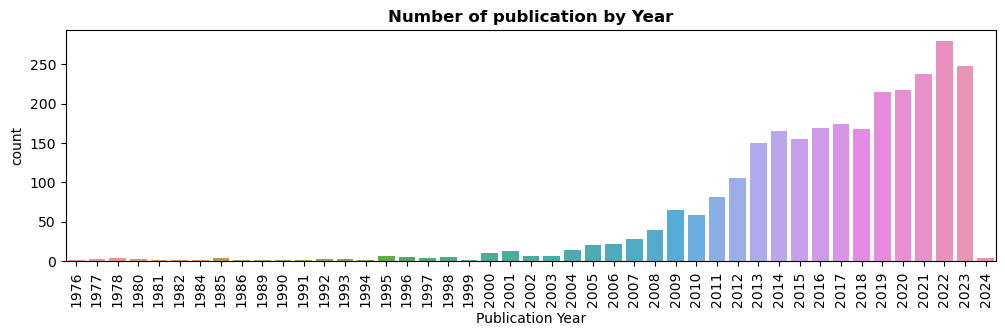

In [119]:
plt.figure(figsize=(12,3))
sns.countplot(data = merge_df, x = 'Publication Year', )
plt.xticks(rotation=90)
plt.title("Number of publication by Year", fontweight='bold')
plt.show()

In [ ]:
# code to generate data table to re-create the visual in Excel for PPT presentation
pub_count_df = merge_df.groupby('Publication Year').agg(
    num_of_pub = ('PMID', 'count')
)
pub_count_df.reset_index(inplace = True)
pub_count_df

## 2.2 Top 20 First Author with the Most Publications

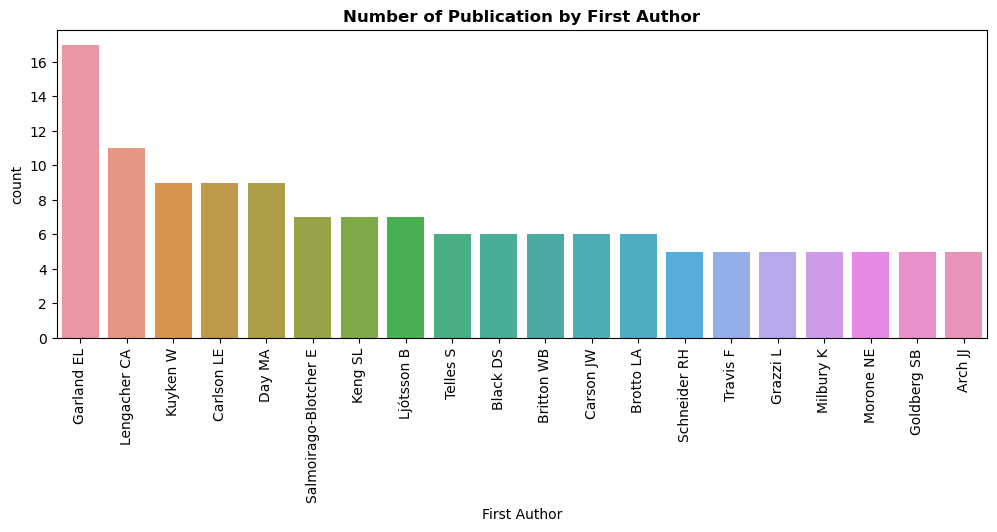

In [120]:
plt.figure(figsize=(12,4))
sns.countplot(data = merge_df, x = 'First Author',
              order = merge_df['First Author'].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.title("Number of Publication by First Author", fontweight='bold')
plt.show()

## 2.3: Top 20 Authors with the Most Publications

In [121]:
# clean up Authors field by tranfomring a string into a list
# example: Pais MV, Kuo CL, Ances BM, Wetherell JL, Lenze EJ, Diniz BS
# >> ['Pais MV', 'Kuo CL', 'Ances BM', 'Wetherell JL', 'Lenze EJ', 'Diniz BS']
merge_df['Authors'] = merge_df['Authors'].str.replace(".","")
merge_df['Authors_list'] = merge_df['Authors'].apply(lambda x: str(x).split(','))
merge_df['Authors_list'] = merge_df['Authors_list'].apply(lambda x: [i.strip() for i in x])


/var/folders/xs/gm48vpks29ggkm34l4ym7q4m0000gn/T/ipykernel_230/4024667667.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merge_df['Authors'] = merge_df['Authors'].str.replace(".","")


In [122]:
merge_df['NumberOfAuthors'] = merge_df['Authors_list'].apply(lambda x: len(x))
median = merge_df['NumberOfAuthors'].median()
mean = merge_df['NumberOfAuthors'].mean().round()
print(f'median number of author per paper is {median}')
print(f'mean number of author per paper is {mean}')

median number of author per paper is 6.0
mean number of author per paper is 6.0


In [123]:
authors_df = merge_df[['PMID', 'Publication Year', 'Authors_list']]
authors_df = authors_df.explode('Authors_list')
authors_df.rename(columns = {'Authors_list': 'Authors'}, inplace = True)
authors_df.reset_index(inplace = True, drop = True)
authors_df.head()

,PMID,Publication Year,Authors
0,9891256,1998,Shapiro SL
1,9891256,1998,Schwartz GE
2,9891256,1998,Bonner G
3,9773769,1998,Kabat-Zinn J
4,9773769,1998,Wheeler E


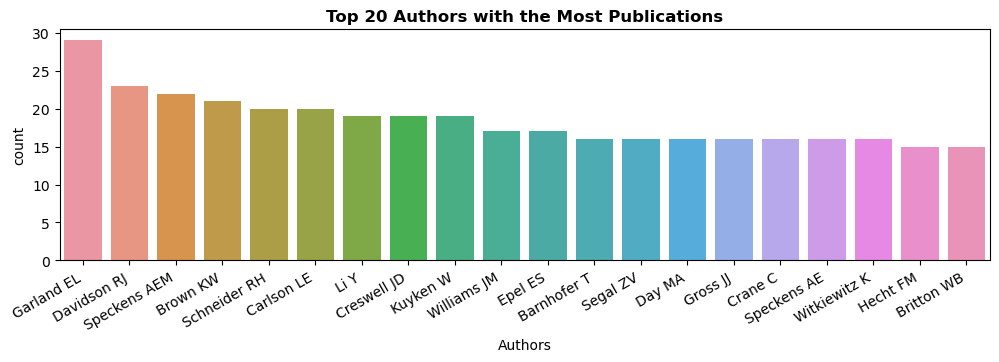

In [124]:
# Most involved author

plt.figure(figsize=(12,3))
sns.countplot(data = authors_df, x = 'Authors',
              order = authors_df['Authors'].value_counts().iloc[:20].index)
plt.xticks(rotation = 30, ha = 'right')
plt.title("Top 20 Authors with the Most Publications", fontweight='bold')
plt.show()

# 3. Text Pre-Processing

## 3.1: Standard Processing

In [125]:
def lemma_pos(word):
    pos = nltk.pos_tag([word])[0][1][0].lower()
    # if not noun, verb, adj, just use noun as default
    if pos not in ('n', 'v', 'j'):
        pos = 'n'
    # if word is an adjective, change from "J" to "A"
    if pos == 'j':
        pos = 'a'
    return pos

def clean_text(sentence):
    # 1. Tokenize into single word units
    tokens = nltk.word_tokenize(sentence)
    # 2. Reduce the case of each word
    tokens_lower = [w.lower() for w in tokens]
    
    # 3.1 Remove all stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_token = [w for w in tokens_lower if w not in stop_words]
    # 3.2 concatenate hyphenated words: eg. self-consciousness > selfconsciousness
    cleaned_token = [w.replace('-','') for w in cleaned_token]
    # 3.3 Remove punctuation
    cleaned_token = [w for w in cleaned_token if w.isalpha()]
    # 3.4 Remove digits
    cleaned_token = [w for w in cleaned_token if w.isdigit() == False]

    # 4. POS tag and keep only nouns, verbs, and adjectives
    tagged = nltk.pos_tag(cleaned_token)
    tags = ['NN', 'NNS', 'NNP', 'NNPS', #noun
            'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', #verb
            'JJ', 'JJR', 'JJS', #adj
            ] 
    tagged_cleaned = [word for (word, pos) in tagged if pos in tags]

    # 5. Lemmatize each word based on POS tag
    lemma = WordNetLemmatizer()
    lemma_token = [lemma.lemmatize(w, pos = lemma_pos(w)) for w in tagged_cleaned]

    # 6. concatenate words back into a 1 sentence
    cleaned_sent = ' '.join(lemma_token)

    return cleaned_sent

In [24]:
def name_clean(names):
    '''Take a string of author names, remove commas between names,
    and remove space within each author's name. For example, 
    "Wang J, Brown K, Jones L" >> "WangJ BrownK JonesL"
    '''
    name_list = names.split(", ")
    name_list = [i.replace(" ", "") for i in name_list]
    name_join = ' '.join(name_list)
    return name_join

In [126]:
# clean the original tokens
merge_df['Title_token'] = merge_df['Title'].apply(lambda x: clean_text(x))
merge_df['Abstract_token'] = merge_df['abstract'].apply(lambda x: clean_text(x))
merge_df['Authors_token'] = merge_df['Authors'].apply(lambda x: name_clean(x))

In [127]:
# merge all tokens together from three fields
merge_df['All_Tokens'] = merge_df[['Authors_token', 'Title_token', 'Abstract_token']].agg(' '.join, axis=1)

In [27]:
# check result
new_fields = ['Title_token', 'Abstract_token', 'Authors_token', 'All_Tokens']
merge_df[new_fields].head()

,Title_token,Abstract_token,Authors_token,All_Tokens
0,effect mindfulnessbased stress reduction medic...,inability cope enormous stress medical educati...,ShapiroSL SchwartzGE BonnerG,ShapiroSL SchwartzGE BonnerG effect mindfulnes...
1,influence mindfulness meditationbased stress r...,objective study test hypothesis stress reducti...,Kabat-ZinnJ WheelerE LightT SkillingsA ScharfM...,Kabat-ZinnJ WheelerE LightT SkillingsA ScharfM...
2,acth transcendental meditation,evaluate effect transcendental meditation hypo...,InfanteJR PeranF MartinezM RoldanA PoyatosR Ru...,InfanteJR PeranF MartinezM RoldanA PoyatosR Ru...
3,clinical study yoga technique university stude...,adult asthmatic range year clinic university s...,VedanthanPK KesavaluLN MurthyKC DuvallK HallMJ...,VedanthanPK KesavaluLN MurthyKC DuvallK HallMJ...
4,autonomic change repeat syllable meaningful ne...,autonomic respiratory variable record voluntee...,TellesS NagarathnaR NagendraHR,TellesS NagarathnaR NagendraHR autonomic chang...


## 3.2 Remove Most Frequent & Infreqent Words

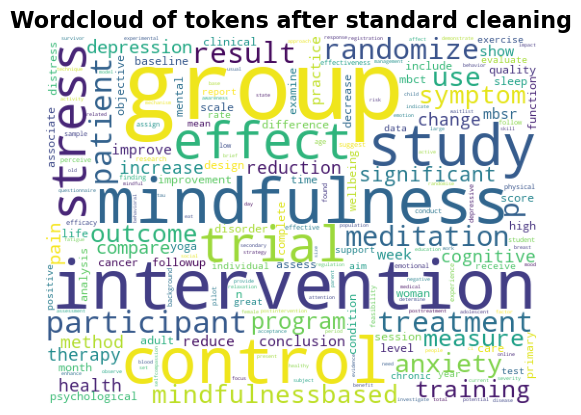

In [128]:
# visualize corpus tokens prior to removing frequent/infrequent words
corpus = merge_df['All_Tokens'].to_list()
corpus_flatten = [w for ls in corpus for w in ls.split()]

token_counter = Counter(corpus_flatten)
plt.figsize = (15,6)
wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate_from_frequencies(token_counter)
plt.imshow(wordcloud) # show wordcloud
plt.axis('off') # to hide x and y axes
plt.title("Wordcloud of tokens after standard cleaning", size=16, fontweight="bold")
plt.show()

### Create Dictionary with Token Appearnce in Documents

In [129]:
corpus = merge_df['All_Tokens'].to_list()
corpus_ls_ls = [doc.split() for doc in corpus]

# use defaultdict to handle new key as we loop through the docs
# word: number of doc the token appears in
word_in_doc_freq = defaultdict(int)

# Iterate through the documents and update the number of documents each word appears in
for doc in corpus_ls_ls:
    for word in set(doc):
        word_in_doc_freq[word] += 1

In [30]:
word_in_doc_freq

defaultdict(int,
            {'experience': 464,
             'intervention': 1835,
             'mindfulnessbased': 1118,
             'effect': 1678,
             'enormous': 4,
             'anxiety': 753,
             'period': 362,
             'reduce': 1000,
             'cope': 49,
             'assess': 706,
             'trait': 123,
             'inability': 7,
             'state': 323,
             'increase': 982,
             'participation': 129,
             'empathy': 43,
             'potential': 411,
             'stress': 1084,
             'indicate': 363,
             'personal': 78,
             'student': 237,
             'finding': 613,
             'spiritual': 58,
             'distress': 389,
             'lead': 245,
             'statistical': 81,
             'SchwartzGE': 3,
             'design': 765,
             'level': 685,
             'consequence': 46,
             'experiment': 47,
             'observe': 339,
             'include': 921,
    

### Words with Low Frequency

In [130]:
# count number of words with 1-10, and 11+ frequency
low_fre_dic = {}
low_fre_dic = {freq: 0 for freq in range(1, 12)}
for word in dict(word_in_doc_freq).keys():
    word_freq = dict(word_in_doc_freq)[word]
    # for words with 1-10 appearance, count how many words with each of the frequency
    if word_freq in range(1, 11):
        low_fre_dic[word_freq] += 1
    else:
    # for other freq, put them in this bucket, 11 meaning 11+
        low_fre_dic[11] += 1

In [131]:
word_doc_freq = list(low_fre_dic.keys())
number_of_words = list(low_fre_dic.values())

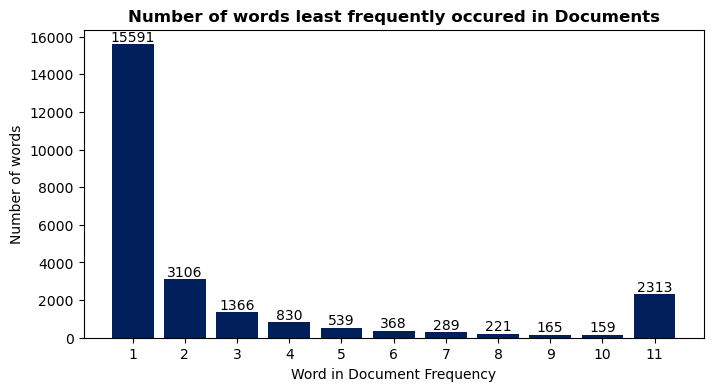

In [132]:
plt.figure(figsize=(8, 4))
ax = plt.bar(word_doc_freq, number_of_words, color = '#011F5B')
plt.xticks(word_doc_freq)

# Annotate each bar with frequency
for bar in ax:
    freq = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, freq, round(freq, 2), ha='center', va='bottom')

# plt.xticks(rotation = 30, ha = 'right')
plt.xlabel('Word in Document Frequency')
plt.ylabel('Number of words')
plt.title('Number of words least frequently occured in Documents', fontweight = "bold")
plt.show()

_Note: How to read this chart: 15,556 words occured in 1 document only. 2,312 words appeared in 11+ documents._

In [34]:
# obtain list of words occuring in 5 or less documents
infrequent_words = [k for k in dict(word_in_doc_freq).keys() if dict(word_in_doc_freq)[k] in range(1,6)]

### Words with High Frequency

In [133]:
# Find words that appear in at least 25% of the documents
total_documents = len(corpus_ls_ls)
threshold = 0.25

most_frequent_word = {word: round(freq / total_documents, 2) for word, freq in word_in_doc_freq.items() if (freq / total_documents) >= threshold}
most_frequent_word

most_frequent_word_sorted = dict(sorted(most_frequent_word.items(), key=lambda item: item[1], reverse=True))

frequent_words = list(most_frequent_word_sorted.keys())
portion_of_doc = list(most_frequent_word_sorted.values())

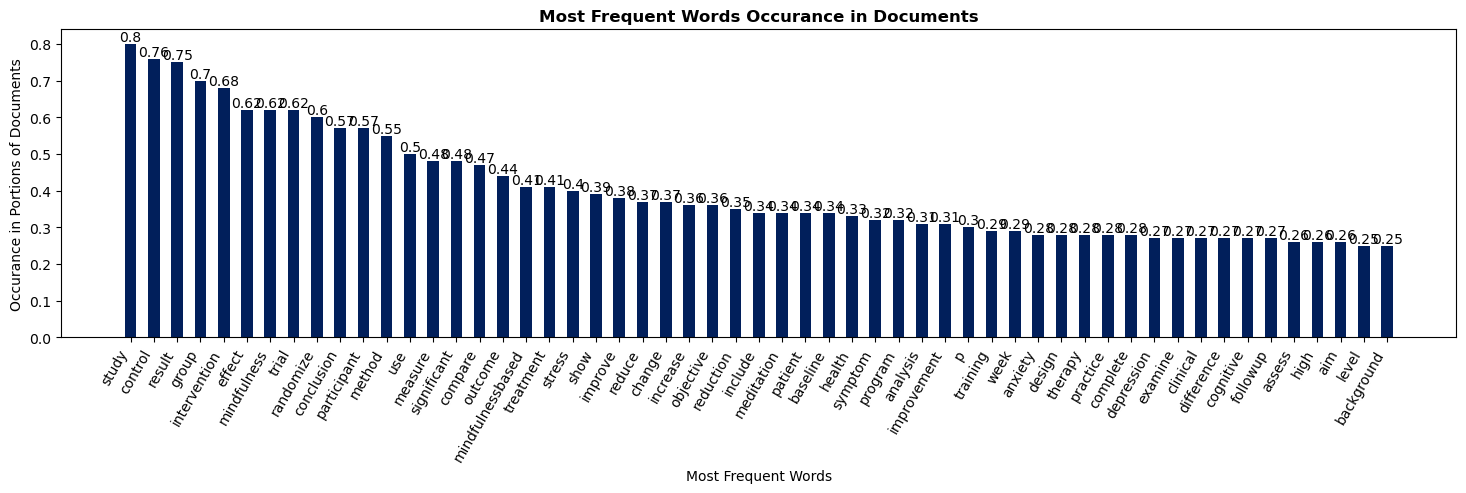

In [134]:
plt.figure(figsize=(18, 4))
ax = plt.bar(frequent_words, portion_of_doc, color = '#011F5B', width=0.5)
plt.xticks(frequent_words)

# Annotate each bar with frequency
for bar in ax:
    freq = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, freq, round(freq, 2), ha='center', va='bottom')

plt.xticks(rotation = 60, ha = 'right')
plt.xlabel('Most Frequent Words')
plt.ylabel('Occurance in Portions of Documents')
plt.title('Most Frequent Words Occurance in Documents', fontweight = "bold")
plt.show()


In [135]:
print(frequent_words)

['study', 'control', 'result', 'group', 'intervention', 'effect', 'mindfulness', 'trial', 'randomize', 'conclusion', 'participant', 'method', 'use', 'measure', 'significant', 'compare', 'outcome', 'mindfulnessbased', 'treatment', 'stress', 'show', 'improve', 'reduce', 'change', 'increase', 'objective', 'reduction', 'include', 'meditation', 'patient', 'baseline', 'health', 'symptom', 'program', 'analysis', 'improvement', 'p', 'training', 'week', 'anxiety', 'design', 'therapy', 'practice', 'complete', 'depression', 'examine', 'clinical', 'difference', 'cognitive', 'followup', 'assess', 'high', 'aim', 'level', 'background']


### Removing Most Frequent and Infrequent words

In [136]:
def clean_text_frequent(sentence, remove_words):
    # 1. Tokenize into single word units
    tokens = nltk.word_tokenize(sentence)

    # 2. Remove words in frequent list
    remove_words = [w for w in tokens if w not in remove_words]
    cleaned_sent = ' '.join(remove_words)
    return cleaned_sent

In [137]:
# remove frequent word
merge_df['All_Tokens_Cleaned'] = merge_df['All_Tokens'].apply(lambda x: clean_text_frequent(x, frequent_words))

In [138]:
# remove infrequent word
merge_df['All_Tokens_Cleaned'] = merge_df['All_Tokens_Cleaned'].apply(lambda x: clean_text_frequent(x, infrequent_words))

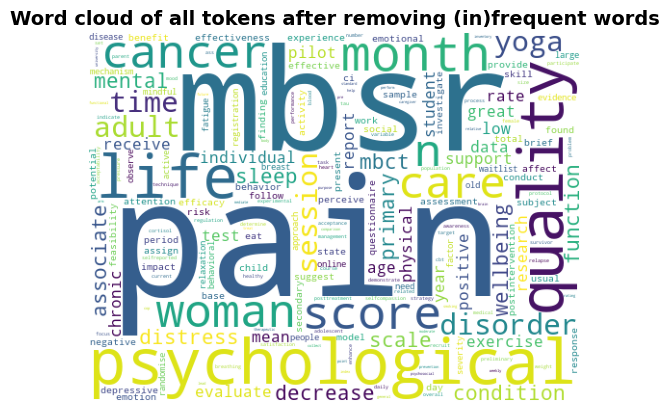

In [139]:
# visualize corpus after removing frequent and infrequent words
corpus = merge_df['All_Tokens_Cleaned'].to_list()
corpus_flatten = [w for ls in corpus for w in ls.split()]
token_counter = Counter(corpus_flatten)
plt.figsize = (15,6)
wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate_from_frequencies(token_counter)
plt.imshow(wordcloud) # show wordcloud
plt.axis('off') # to hide x and y axes
plt.title("Word cloud of all tokens after removing (in)frequent words", size=14, fontweight="bold")
plt.show()

# 4. LDA Topic Modeling with Gensim

In [56]:
# reference: https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/
# reference: https://radimrehurek.com/gensim/models/ldamodel.html
# Why not use tfidf: https://datascience.stackexchange.com/questions/21950/why-should-we-not-feed-lda-with-tf-idf-input

genism_corpus = [i.split() for i in merge_df['All_Tokens_Cleaned'].to_list()]

# create corpus
genism_dict = corpora.Dictionary(genism_corpus)

# create term-document frequency matrix
dt_freq_matrix = [genism_dict.doc2bow(word) for word in genism_corpus]


2023-12-18 01:10:05 Liang-Yuns-MacBook-Air.local gensim.corpora.dictionary[230] INFO adding document #0 to Dictionary<0 unique tokens: []>
2023-12-18 01:10:05 Liang-Yuns-MacBook-Air.local gensim.corpora.dictionary[230] INFO built Dictionary<3490 unique tokens: ['ShapiroSL', 'address', 'cascade', 'consequence', 'cope']...> from 2709 documents (total 248554 corpus positions)
2023-12-18 01:10:05 Liang-Yuns-MacBook-Air.local gensim.utils[230] INFO Dictionary lifecycle event {'msg': "built Dictionary<3490 unique tokens: ['ShapiroSL', 'address', 'cascade', 'consequence', 'cope']...> from 2709 documents (total 248554 corpus positions)", 'datetime': '2023-12-18T01:10:05.833343', 'gensim': '4.3.0', 'python': '3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]', 'platform': 'macOS-13.4-arm64-arm-64bit', 'event': 'created'}


In [71]:
# reference: https://radimrehurek.com/gensim/models/coherencemodel.html
# Metrics: https://www.baeldung.com/cs/topic-modeling-coherence-score

perplexity = []
coherence_umass = []
coherence_cv = []

lda_genism = gensim.models.ldamodel.LdaModel
for i in range(2, 21):
    lda_genism_model = lda_genism(dt_freq_matrix,
                                num_topics = i,
                                id2word = genism_dict,
                                passes = 50,
                                chunksize = 2709, # entire corpus
                                alpha = 'auto',
                                eta = 'auto'
                                )

    # perplexity score
    # https://stackoverflow.com/questions/55278701/gensim-topic-modeling-with-mallet-perplexity
    perplexity_bound = lda_genism_model.log_perplexity(dt_freq_matrix)
    perplexity_score = np.exp2(-1 * perplexity_bound)
    perplexity.append(perplexity_score)

    # calculate C_V Coherence Score
    c_v = CoherenceModel(model = lda_genism_model, 
                        texts = genism_corpus, 
                        coherence = 'c_v')
    coherence = c_v.get_coherence()  
    coherence_cv.append(coherence)

    # calculate UMASS coherence score
    umass = CoherenceModel(model = lda_genism_model, 
                        texts = genism_corpus, 
                        coherence = 'u_mass')
    coherence = umass.get_coherence()  
    coherence_umass.append(coherence)    



2023-12-18 01:21:34 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO using autotuned alpha, starting with [0.5, 0.5]
2023-12-18 01:21:34 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO using serial LDA version on this node
2023-12-18 01:21:34 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 2709 documents, updating model once every 2709 documents, evaluating perplexity every 2709 documents, iterating 50x with a convergence threshold of 0.001000
2023-12-18 01:21:35 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO -8.558 per-word bound, 376.9 perplexity estimate based on a held-out corpus of 2709 documents with 248554 words
2023-12-18 01:21:35 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO PROGRESS: pass 0, at document #2709/2709
2023-12-18 01:21:36 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO optimized alpha [0.818

## 4.1 Identify optimal n with Umass Coherence Score

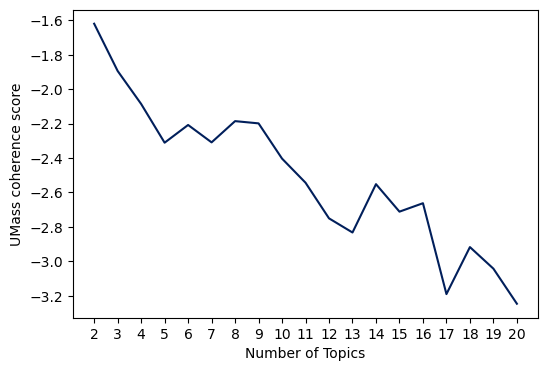

In [72]:
plt.figure(figsize=(6,4))
plt.style.use("seaborn-v0_8-muted")
plt.plot(range(2, 21), coherence_umass, color = '#011F5B')
plt.xticks(range(2, 21))
plt.xlabel("Number of Topics")
plt.ylabel("UMass coherence score")
# plt.title("Optimal Number of Topics by UMass Coherence Score")
plt.show()

_Optimal n = 20_

## 4.2 Training the Final Model

In [87]:
n_topics = 20

In [140]:
lda_genism_model = lda_genism(dt_freq_matrix,
                            num_topics = n_topics,
                            id2word = genism_dict,
                            chunksize = 2709, # entire corpus
                            passes = 100,
                            alpha = 'auto',
                            eta = 'auto'
                            )

c_v = CoherenceModel(model = lda_genism_model, 
                    texts = genism_corpus, 
                    coherence = 'c_v')

coherence_cv = c_v.get_coherence()  
print(f'cv coherence score: {coherence_cv}')

umass = CoherenceModel(model = lda_genism_model, 
                    texts = genism_corpus, 
                    coherence = 'u_mass')
coherence_mass = umass.get_coherence()  
print(f'umass coherence score: {coherence_mass}')


2023-12-18 17:58:27 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
2023-12-18 17:58:27 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO using serial LDA version on this node


2023-12-18 17:58:27 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO running online (multi-pass) LDA training, 20 topics, 100 passes over the supplied corpus of 2709 documents, updating model once every 2709 documents, evaluating perplexity every 2709 documents, iterating 50x with a convergence threshold of 0.001000
2023-12-18 17:58:28 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO -9.311 per-word bound, 635.3 perplexity estimate based on a held-out corpus of 2709 documents with 248554 words
2023-12-18 17:58:28 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO PROGRESS: pass 0, at document #2709/2709
2023-12-18 17:58:29 Liang-Yuns-MacBook-Air.local gensim.models.ldamodel[230] INFO optimized alpha [0.04701352, 0.05051901, 0.055010617, 0.04970527, 0.050207525, 0.050659522, 0.045975927, 0.045933083, 0.049632292, 0.04604709, 0.047152307, 0.050176915, 0.046465863, 0.053183362, 0.048561115, 0.046328045, 0.053627454, 0.04962131, 0.055266835, 0.045282125

cv coherence score: 0.395926604421206
umass coherence score: -3.1395805736919327


## 4.3 Extract Words within Each Topic

In [141]:
# extract top 10 token and their probability
topic_keyords_prob = [[(k, token, score) for token, score in lda_genism_model.show_topic(k, topn=10)] 
                                    for k in range(0, n_topics)]

# extract just top 10 tokens per topic
topic_keyords_lst = {k: [token for token, score in lda_genism_model.show_topic(k, topn=10)] 
                                    for k in range(0, n_topics)}

# use second one to see top 10 words
for i in topic_keyords_lst:
    print(f'{str(i)}: {str(topic_keyords_lst[i])}')

0: ['child', 'student', 'adolescent', 'parent', 'mental', 'school', 'skill', 'distress', 'support', 'university']
1: ['pain', 'chronic', 'intensity', 'headache', 'low', 'interference', 'catastrophizing', 'disability', 'exercise', 'rating']
2: ['cancer', 'quality', 'life', 'breast', 'fatigue', 'survivor', 'feasibility', 'psychological', 'woman', 'distress']
3: ['mbct', 'depressive', 'relapse', 'rumination', 'tau', 'individual', 'experience', 'episode', 'depressed', 'eeg']
4: ['acceptance', 'online', 'act', 'substance', 'alcohol', 'condition', 'relapse', 'prevention', 'psychological', 'disorder']
5: ['positive', 'affect', 'negative', 'emotional', 'emotion', 'selfcompassion', 'regulation', 'wellbeing', 'psychological', 'mbi']
6: ['caregiver', 'relaxation', 'memory', 'dementia', 'muscle', 'family', 'life', 'session', 'progressive', 'technique']
7: ['smoking', 'diabetes', 'mt', 'type', 'cessation', 'expression', 'smoker', 'abstinence', 'gene', 'quit']
8: ['mbsr', 'adult', 'old', 'exercise',

## 4.4 Extract Topic Probability for Each Document

In [90]:
# extract topic prob for each document
doc_topics = [lda_genism_model.get_document_topics(doc, minimum_probability=0) for doc in dt_freq_matrix]

In [91]:
# get prob of each topic, also extract top topic and associated probability
doc_topics_prob = []
for doc in doc_topics:
    topic_prob = []
    for topic, prob in doc:
        topic_prob.append(prob)
    # get top topic number
    topic_prob.append(np.array(topic_prob).argmax())
    # get top topic prob
    topic_prob.append(max(topic_prob[:n_topics]))
    # get second topic
    topic_prob.append(np.argsort(topic_prob[:n_topics])[-2])
    # get second topic prob.
    topic_prob.append(sorted(topic_prob[:n_topics])[1])
    doc_topics_prob.append(tuple(topic_prob))

In [92]:
# make list of list into a df to be merged with the original dataframe
topic_df = pd.DataFrame(doc_topics_prob)
topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.000774,0.000798,0.001379,0.081402,0.000747,0.000778,0.001520,0.001147,0.001170,0.059677,...,0.000729,0.000647,0.000654,0.000562,0.000958,0.186923,11,0.657993,19,0.000596
1,0.000636,0.269564,0.184140,0.112612,0.000614,0.000640,0.001250,0.241925,0.000962,0.181220,...,0.000599,0.000532,0.000538,0.000462,0.000788,0.000749,1,0.269564,7,0.000490
2,0.000636,0.000656,0.001134,0.000881,0.000614,0.000640,0.001250,0.814750,0.000962,0.001009,...,0.000599,0.000532,0.171568,0.000462,0.000788,0.000749,7,0.814750,16,0.000490
3,0.000526,0.000542,0.077435,0.000728,0.000508,0.000529,0.001033,0.466643,0.000795,0.000834,...,0.000495,0.000440,0.000444,0.000382,0.000651,0.000619,7,0.466643,10,0.000405
4,0.000572,0.021797,0.110847,0.000792,0.000552,0.000575,0.001123,0.763787,0.000864,0.000907,...,0.000539,0.000478,0.000483,0.000416,0.000708,0.033707,7,0.763787,2,0.000441


In [93]:
topic_df = topic_df.rename(columns={n_topics: 'Topic1', 
                                    n_topics+1: 'Topic1_Prob',
                                    n_topics+2: 'Topic2',
                                    n_topics+3: 'Topic2_Prob'
                                    })
topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,Topic1,Topic1_Prob,Topic2,Topic2_Prob
0,0.000774,0.000798,0.001379,0.081402,0.000747,0.000778,0.001520,0.001147,0.001170,0.059677,...,0.000729,0.000647,0.000654,0.000562,0.000958,0.186923,11,0.657993,19,0.000596
1,0.000636,0.269564,0.184140,0.112612,0.000614,0.000640,0.001250,0.241925,0.000962,0.181220,...,0.000599,0.000532,0.000538,0.000462,0.000788,0.000749,1,0.269564,7,0.000490
2,0.000636,0.000656,0.001134,0.000881,0.000614,0.000640,0.001250,0.814750,0.000962,0.001009,...,0.000599,0.000532,0.171568,0.000462,0.000788,0.000749,7,0.814750,16,0.000490
3,0.000526,0.000542,0.077435,0.000728,0.000508,0.000529,0.001033,0.466643,0.000795,0.000834,...,0.000495,0.000440,0.000444,0.000382,0.000651,0.000619,7,0.466643,10,0.000405
4,0.000572,0.021797,0.110847,0.000792,0.000552,0.000575,0.001123,0.763787,0.000864,0.000907,...,0.000539,0.000478,0.000483,0.000416,0.000708,0.033707,7,0.763787,2,0.000441


In [94]:
# concat topic probability results with original dataframe
merge_df_final = pd.concat([merge_df, topic_df], axis = 1)


In [95]:
# extract topic percentage for each doc
merge_df_final['Topic1'].value_counts()

6     305
11    247
2     196
9     191
4     146
7     144
13    141
19    133
8     127
3     127
15    127
16    120
18    114
10    111
14    110
12     84
5      76
0      74
1      68
17     68
Name: Topic1, dtype: int64

In [96]:
# export the final dataframe for further anlaysis in Excel
merge_df_final.to_csv("results_vF2.csv", index = False)

# Un-Used Codes

## Bigram for Gensim LDA

In [ ]:
# # reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

# from gensim.models import Phrases
# import gensim.corpora as corpora

# # list (document) of list (words): 
# genism_corpus = [i.split() for i in merge_df['All_Tokens_Cleaned'].to_list()]

# # Add bigrams to genism_corpus (only ones that appear 27 times (1% of total doc) or more).
# # Compute bigrams.
# bigram = Phrases(genism_corpus, min_count = 27)
# for idx in range(len(genism_corpus)):
#     for token in bigram[genism_corpus[idx]]:
#         if '_' in token:
#             # Token is a bigram, add to genism_corpus document.
#             genism_corpus[idx].append(token)


# # create dictionary
# genism_dict = corpora.Dictionary(genism_corpus)

# # create term-document frequency matrix
# dt_freq_matrix = [genism_dict.doc2bow(word) for word in genism_corpus]

## NER with UMLS using spacy & scispacy

In [ ]:
# # reference: https://gbnegrini.com/post/biomedical-text-nlp-scispacy-named-entity-recognition-medical-records/
# import spacy
# import scispacy

# #This will take a few minutes to load
# from scispacy.linking import EntityLinker


# nlp =  spacy.load('en_core_sci_sm')
# nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})
# linker = nlp.get_pipe("scispacy_linker")


In [ ]:

# def spacy_NER(text):
#     linked_entity = []
#     doc = nlp(text)
#     for entity in doc.ents:
#         # print(entity)
#         try:
#             # print(linker.kb.cui_to_entity[entity._.kb_ents[0][0]][1])
#             linked_entity.append(linker.kb.cui_to_entity[entity._.kb_ents[0][0]][1])
#         except IndexError:
#             continue
#     linked = ' '.join(linked_entity)
#     return linked

In [ ]:
# merge_df['UMLS_token'] = merge_df['All_Tokens_Cleaned'].apply(lambda x: spacy_NER(x))

In [ ]:
# corpus = merge_df['UMLS_token'].to_list()
# corpus_flatten = [w for ls in corpus for w in ls.split()]
# token_counter = Counter(corpus_flatten)
# plt.figsize = (15,6)
# wordcloud = WordCloud (
#                       background_color = 'white',
#                       width = 512,
#                       height = 384
#                           ).generate_from_frequencies(token_counter)
# plt.imshow(wordcloud) # show wordcloud
# plt.axis('off') # to hide x and y axes
# plt.title("Word cloud of Title, Abstract, and Author_v2", size=16, fontweight="bold")
# plt.show()

## LDA: LatentDirichletAllocation - SKLEARN

In [ ]:

# count_vectorizer = CountVectorizer(ngram_range=(1,1), 
#                                            min_df = 10,
#                                            analyzer="word", 
#                                            stop_words="english")
# count_unigram = count_vectorizer.fit_transform(merge_df['All_Tokens_Cleaned'])
# n_topics = 14
# # alpha_values = [0.1, 0.5, 1.0, 5.0]
# # beta_values = [0.01, 0.1, 0.5, 1.0]

# lda = LatentDirichletAllocation(n_components = n_topics, 
#                                 random_state = 42,
#                                 max_iter = 50,
#                                 learning_decay = 0.5, # same as gensim
#                                 )
# data_lda = lda.fit(count_unigram)


# # source: https://stackoverflow.com/questions/65550639/get-most-probable-words-for-each-topic

# def ntopwlst(model, features, ntopwords):
#     '''create a list of the top topc words'''
#     output = {}
#     for topic_idx, topic in enumerate(model.components_): # compose output message with top words
#         key_words = [features[i] for i in topic.argsort()[:-ntopwords - 1:-1]] # [start (0 if omitted): end : slicing increment]
#         output[topic_idx] = key_words
#         # table = [(topic_idx, i, key_words[i-1]) for i in range(1, ntopwords + 1)]
#         # output.extend(table)
#     return output

# ntopwords = 10 # change this to show more words for the topic selector (20)
# cnt_feature_names = count_vectorizer.get_feature_names_out()
# topwds = ntopwlst(lda, cnt_feature_names, ntopwords)


## Visualize cv coherence score

In [ ]:
# plt.style.use("seaborn-v0_8-muted")
# plt.plot(range(2, 21), coherence_cv)
# plt.xticks(range(2, 21))
# plt.xlabel("Number of Clusters")
# plt.ylabel("coherence score cv")
# plt.title("LDA Optimal Number of Cluster by coherence cv")
# plt.show()